<a href="https://colab.research.google.com/github/jodog0412/US-STOCKS-INVESTMENT-ASSISTANCE/blob/master/US_STOCK_INVESTMENT_ASSISTANCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Environment&Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/Colab Notebooks/US-STOCKS-INVESTMENT-ASSISTANCE

In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install finance-datareader --upgrade

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
yf.pdr_override()
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
startdate='2019-01-01'
enddate='2023-01-23'

#2. Portfolio

## 1) Load spreadsheet

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.auth import default
import gspread
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
sheet=gc.open('US_STOCK').sheet1

## 2) Analyze portfolio

In [ ]:
class portfolio:
    def __init__(self,sheet):
        data=pd.DataFrame(sheet.get_all_values())
        pf=pd.DataFrame(data=data.values,
                        columns=["TICKER","TAG","AVER_PRICE","STOCK_NUM","STOCK_QUANTITY"]).sort_values(by="TICKER")
        self.pf=pf.sort_values("STOCK_QUANTITY",ascending=False)
        
    def plot(self):
        data=self.pf
        pf_plt=plt.pie(data["STOCK_QUANTITY"],labels=data.loc[:,"TICKER"],
                       autopct='%.1f%%',startangle=90)
        return(plt.show(pf_plt))
    
    def calcProfit(self,date):
        ticker=self.pf.loc[:,"TICKER"].values
        data=yf.download(list(ticker),start=startdate,end=enddate,progress=False)
        last_price=data['Adj Close'].iloc[-1]
        profit=(last_price/(self.pf)['AVER_PRICE'].values.astype(float)-1)*100
        profit=profit.sort_values(ascending=False)
        return(profit)

In [ ]:
sheetData=portfolio(sheet)
sheetData.plot()

NameError: ignored

## 3. TICKER SEARCH

## 1) Load Tickers

In [ ]:
nyse, ndq = fdr.StockListing('NYSE'), fdr.StockListing('NASDAQ')

100%|██████████| 4432/4432 [00:31<00:00, 142.78it/s]


##2) Load Sectors

In [ ]:
# sectors=set(nyse['Industry'].values)
sectors=list(set(ndq['Industry'].values))
pd.Series(sectors).sort_values()

41                 가정용품
0       개인, 가정 용품 및 서비스
50           건설 및 엔지니어링
30    건설장비 및 대형차, 기차, 배
54                건축 자재
55                교육서비스
56               기타 금융업
18            다양한 금융서비스
51              다양한 소매업
4                 레저 상품
36               메탈&마이닝
44             미디어 및 출판
3          반도체 및 반도체 장비
8                    보험
39                복합 기업
49            부동산 운영 관리
45               비즈니스교육
24                 사무기기
38       생명과학 및 메디컬 리서치
21                   석탄
29              섬유 및 의류
14        소프트웨어 및 IT서비스
57              수도 유틸리티
5               식품 및 담배
53            식품 및 약품소매
25              오일 및 가스
26     오일 및 가스 장비 및 서비스
35              용기 및 포장
34                  우라늄
9             우주항공 및 국방
43               운송 인프라
2                   운송업
13                   은행
46                   음료
28         자동차 및 자동차 부품
23                재생에너지
10              전기 유틸리티
27          전문 및 상업 서비스
52               전문품 상점
17           전자 장비 및 부품
48                   제약
15             종

## 2) Search tickers

In [ ]:
class tickerSearch:
    def __init__(self,index,sector):
        if index=='NYSE':
            data = dict(list(nyse.groupby('Industry')))
        if index=='NASDAQ':
            data = dict(list(ndq.groupby('Industry')))
        tickers=list(data[sector]['Symbol'].values)
        self.tickerFilt=[ticker for ticker in tqdm(tickers) if yf.download(ticker,progress=False).empty!=True]

    def download(self):
        tickers=self.tickerFilt
        data=yf.download(tickers,start=startdate,end=enddate)
        result=(data['Adj Close'].iloc[-1]/data['Adj Close'].iloc[0]-1).sort_values(ascending=False).dropna()
        return result

In [ ]:
tickerInit=tickerSearch('NYSE','식품 및 약품소매')
searchResult=tickerSearch.download(tickerInit)


100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

[                       0%                       ]

[*********************100%***********************]  11 of 11 completed


In [ ]:
filterN=10
searchTickers=searchResult.index[:filterN]

## 4. COMPARE FINANCIALS

In [ ]:
def financialCompare(command):
    if command=='SEARCH':
        tickers=tickerDict['SEARCH']
    else:
        tickers=tickerDict['WATCH']
    def getFinancial(ticker):
        def return_(info, key):
            try: return info[key]
            except KeyError: return "NaN"
        info=yf.Ticker(ticker).info
        infoCustom=[return_(info,"trailingPE"), return_(info,"forwardPE"), return_(info,"priceToBook"),
                    return_(info,"pegRatio"), return_(info,"returnOnEquity"),return_(info,"shortPercentOfFloat"),
                    return_(info,"quickRatio")]
        return infoCustom

    financial=[getFinancial(ticker) for ticker in tqdm(tickers)]
    df=pd.DataFrame(data=financial,
                    index=tickers,
                    columns=['PER', 'FPER', 'PBR',
                             'PEGR', 'ROE', 'short%', 'qRatio'])
    df=df.sort_values('FPER',ascending=False)
    return df

In [ ]:
tickerDict={
    'SEARCH':searchTickers,
    'WATCH':['CLFD','ON','ONTO','RELL','META','EQNR','STEM','ANDE','POST','UFPT']
}

In [ ]:
financialCompare('WATCH')

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


,PER,FPER,PBR,PEGR,ROE,short%,qRatio
UFPT,24.569672,27.500000,4.017828,NaN,0.17532,0.0180,1.289
POST,7.779896,23.380209,1.619584,0.91,0.22393,0.0338,1.492
ONTO,18.615566,18.571764,2.490298,1.17,0.13854,0.0234,4.649
META,13.352284,18.181473,3.076841,-0.88,0.22398,0.0130,2.336
ON,17.226278,15.698448,5.412844,0.68,0.35147,0.0550,1.898
CLFD,21.152779,15.139165,7.130150,NaN,0.39269,0.1154,1.473
ANDE,9.032745,14.344000,1.002684,1.30,0.14967,0.0230,0.491
RELL,14.859756,13.846591,2.316100,0.76,0.16850,0.0339,1.546
EQNR,4.116556,5.061889,2.291022,0.79,0.60734,NaN,1.341
STEM,8.600000,-19.907406,2.878950,NaN,-0.20334,0.1352,1.821


In [ ]:
data=yf.download(tickerDict['WATCH'],start=startdate,end=enddate)
result=(data['Adj Close'].iloc[-1]/data['Adj Close'].iloc[0]-1).sort_values(ascending=False).dropna()
result

[*********************100%***********************]  10 of 10 completed


CLFD    5.879100
ON      2.948748
UFPT    2.769427
RELL    2.175847
EQNR    0.771678
POST    0.540913
ANDE    0.286036
META    0.027196
dtype: float64

#5. Visualized Financials

In [ ]:
def revenueGrowthTable(tickers):
    revDict={}
    for ticker in tickers:
        data=yf.Ticker(ticker).earnings
        revGrowth=[(data.iloc[i+1,0]-data.iloc[i,0])/data.iloc[i,0]*100 for i in range(3)]
        revDict[ticker]=revGrowth
    result=pd.DataFrame(data=revDict)
    return result

In [ ]:
revenueGrowthTable(tickerDict['WATCH'])

 13%|█▎        | 2/15 [03:14<21:02, 97.13s/it]


,CLFD,ON,ONTO,RELL,META,EQNR,STEM,ANDE,POST,UFPT
0,9.455983,-6.131024,11.728954,-6.452968,26.610910,-19.915729,149.601820,162.799642,-17.075918,4.161613
1,51.227505,-4.764494,81.923268,13.495362,21.596390,-27.273450,106.853920,0.766776,5.724899,-9.581563
2,92.450002,28.254995,41.761846,26.949140,37.182574,93.963237,250.816647,56.387406,17.477463,15.022885


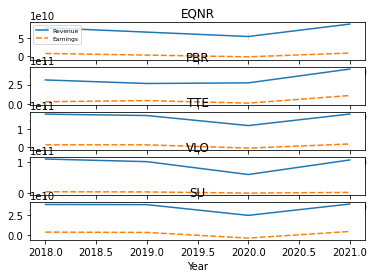

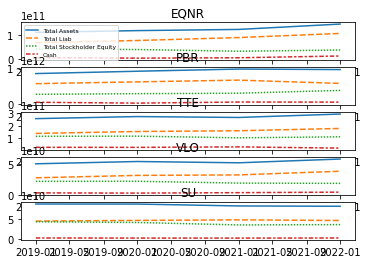

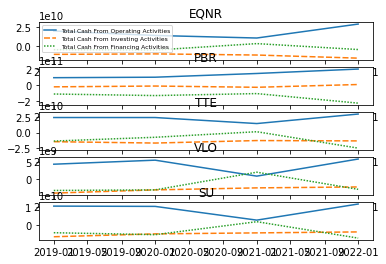

In [ ]:

def plt_balance(tickerlist):
    fig, axs = plt.subplots(len(tickerlist))
    for i in range(0,len(tickerlist)):
        #get datas for balance sheet
        ticker_yf=yf.Ticker(tickerlist[i])
        balance=ticker_yf.balance_sheet.loc[["Total Assets","Total Liab","Total Stockholder Equity","Cash"]]
        balance=balance.transpose().sort_index()
        #plotting
        sns.lineplot(data=balance,ax=axs[i],legend=False)
        if i==0:
            axs[i].legend(["Total Assets","Total Liab","Total Stockholder Equity","Cash"],
                          loc=2,
                          prop={'size': 6})
        axs[i].set_title(tickerlist[i])
    plt.show()

def plt_cashflow(tickerlist):
    fig, axs = plt.subplots(len(tickerlist))
    for i in range(0,len(tickerlist)):
        #get datas for balance sheet
        ticker_yf=yf.Ticker(tickerlist[i])
        cashflow=ticker_yf.cashflow.loc[["Total Cash From Operating Activities",
                                         "Total Cashflows From Investing Activities",
                                         "Total Cash From Financing Activities"]]
        cashflow=cashflow.transpose().sort_index()
        sns.lineplot(data=cashflow,ax=axs[i],legend=False)
        if i==0:
            axs[i].legend(["Total Cash From Operating Activities",
                           "Total Cash From Investing Activities",
                           "Total Cash From Financing Activities"],
                          loc=2,
                          prop={'size': 6})
        axs[i].set_title(tickerlist[i])
    plt.show()

plt_balance(view)
plt_cashflow(view)